## Customer Churn Prediction

 Step 1. Imports

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Metrics & utilities
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import joblib
import warnings
warnings.filterwarnings("ignore")

# Display settings
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.05)
pd.set_option('display.max_columns', 200)

# Step 2. Load the data

In [2]:
# Load dataset (adjust path if needed)
df = pd.read_csv("dataset/customer_data.csv")
print("Shape:", df.shape)
df.head()

Shape: (10000, 12)


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Data representation 
1. df.info()
2. df.isnull().sum()
3. df.describe()
4. df.value_counts()

#  Why am I using the function 
    To understand the structure of the dataset:
   - How many rows and columns?
   - What are the data types?
   - Are there missing values?

In [ ]:
# Info & summary
df.info()
df.describe(include='all')

# Missing values
print("\nMissing values per column:")
df.isnull().sum()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB

Missing values per column:


customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [5]:
df.describe() #-->its used fo statical summary

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


## Statistical Summary Overview

The dataset contains 10,000 customer records with numerical and binary
features describing demographic, financial, and engagement information.
The target variable `churn` indicates whether a customer has left the
company, with approximately 20% of customers labeled as churned.

Customer credit score, age, tenure, balance, and activity status show
substantial variation, suggesting strong predictive potential. The
presence of binary engagement features such as `active_member` and
`credit_card` adds important behavioral signals.

The dataset contains no missing values, and the churn class exhibits
moderate imbalance, requiring evaluation metrics beyond accuracy.


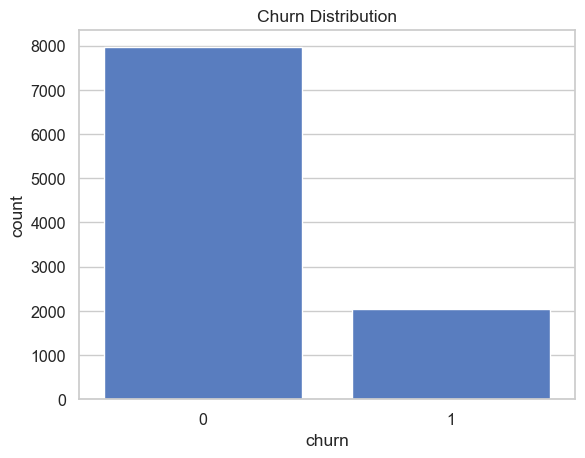

churn
0    0.7963
1    0.2037
Name: proportion, dtype: float64

In [ ]:
# analyse the target variables 
sns.countplot(x="churn", data=df) # count plot is used to for catogorical variable that's why i used
                                       
plt.title("Churn Distribution")
plt.show()

df["churn"].value_counts(normalize=True)




## The churn distribution
 shows moderate class imbalance, so I avoided accuracy and focused on recall, precision, and ROC-AUC for evaluation. and the imbalanced data

# Step 4. Exploratory Data Analysis (visualizations)

We'll look at distributions of numeric features, relationships with churn and categorical features

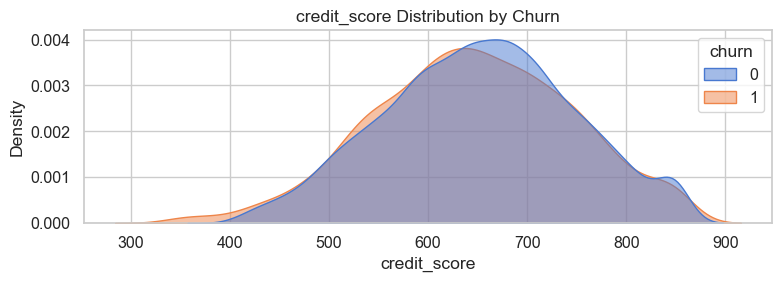

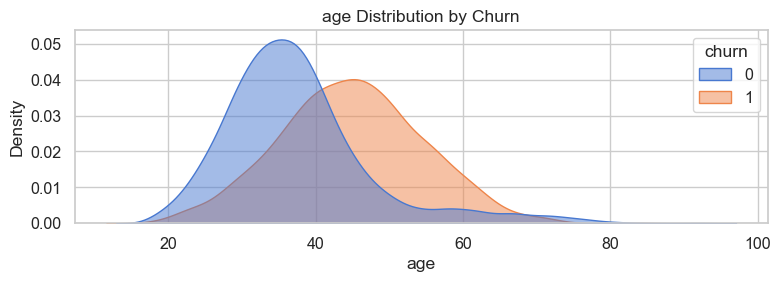

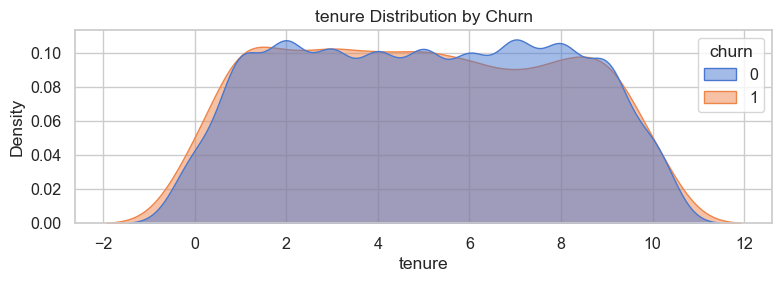

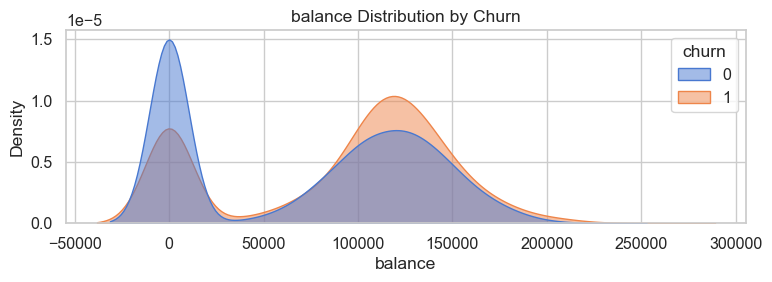

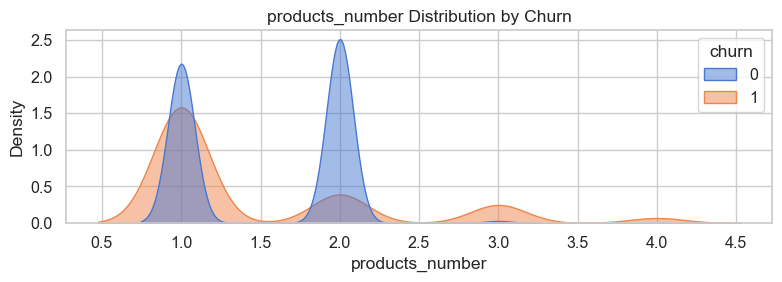

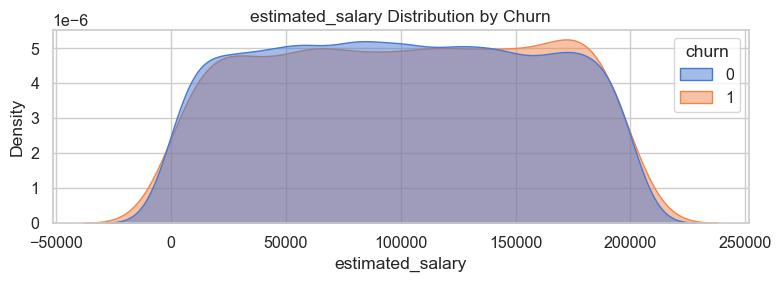

In [ ]:
#  Why define numeric columns
#  KDE plots work only with numeric features.

num_cols = ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'estimated_salary']

# --- Distribution plots
for col in num_cols:
    plt.figure(figsize=(8,3))
    sns.kdeplot(data=df, x=col, hue='churn', fill=True, common_norm=False, alpha=0.5) #-->kde is used to for check the distribution
    plt.title(f'{col} Distribution by Churn')
    plt.tight_layout()
    plt.show()

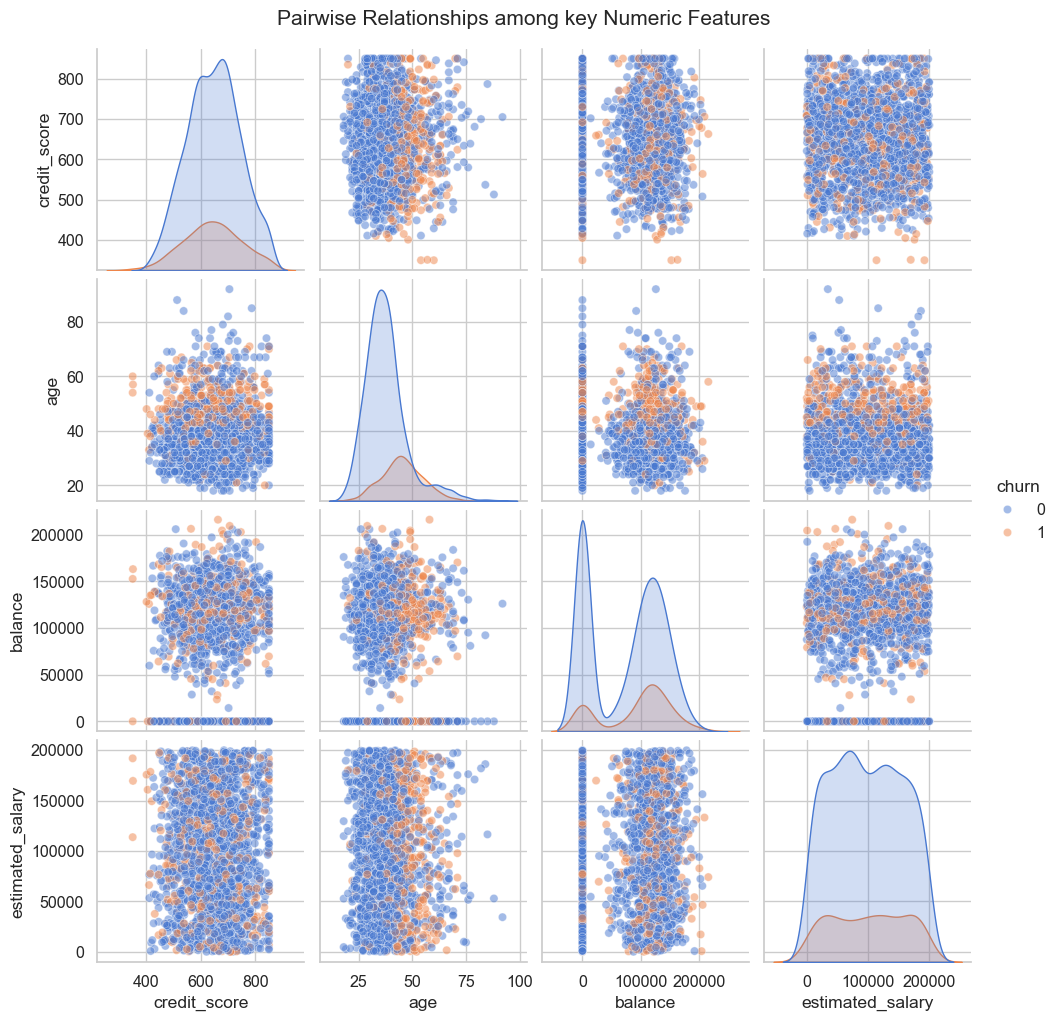

In [19]:
#   Why sample the data
#  Pairplot is computationally expensive on large datasets.
#  Sampling improves speed without losing overall pattern.
sns.pairplot(
    df.sample(frac=0.2, random_state=42),
    vars=['credit_score', 'age', 'balance', 'estimated_salary'],
    hue='churn',
    diag_kind='kde',
    plot_kws={'alpha':0.5}
)

plt.suptitle('Pairwise Relationships among key Numeric Features', y=1.02)
plt.show()


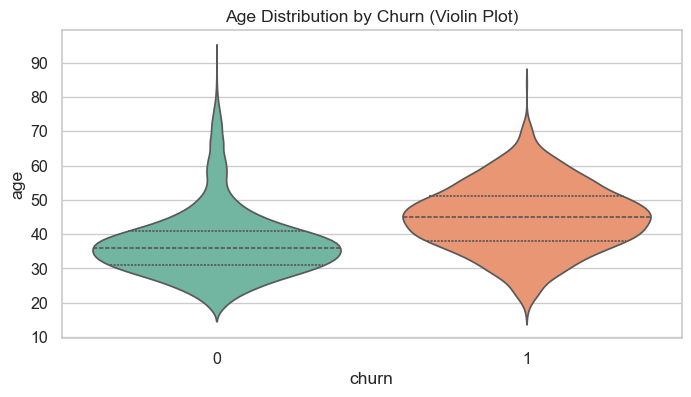

In [20]:
#  Why violin plot
#  Violin plot shows:
#    . Distribution shape
#    . Median
#    . Quartiles
#    Better than boxplot alone
plt.figure(figsize=(8,4))
sns.violinplot(
    data=df,
    x='churn',
    y='age',
    inner='quart',
    palette='Set2'
)

plt.title('Age Distribution by Churn (Violin Plot)')
plt.show()


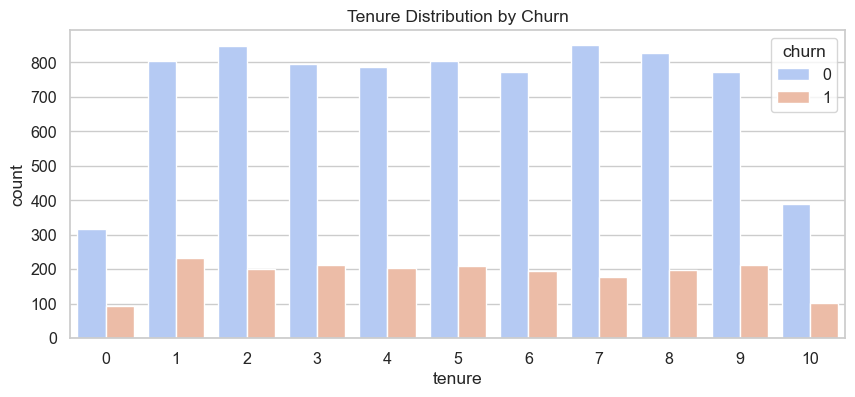

In [22]:
#  Why countplot for tenure?
#  Tenure is a discrete variable (0–10 years).
#   Countplot shows frequency clearly.
plt.figure(figsize=(10,4))
sns.countplot(
    data=df,
    x='tenure',
    hue='churn',
    palette='coolwarm'
)

plt.title('Tenure Distribution by Churn')
plt.show()


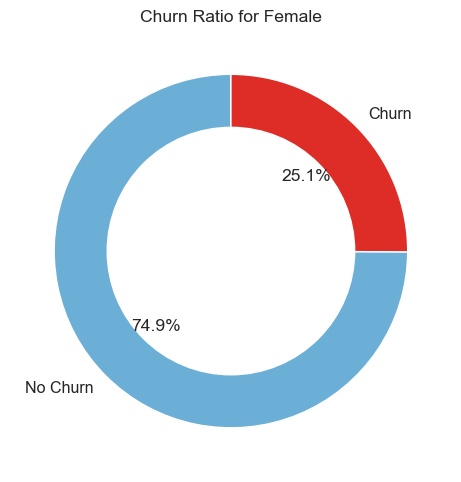

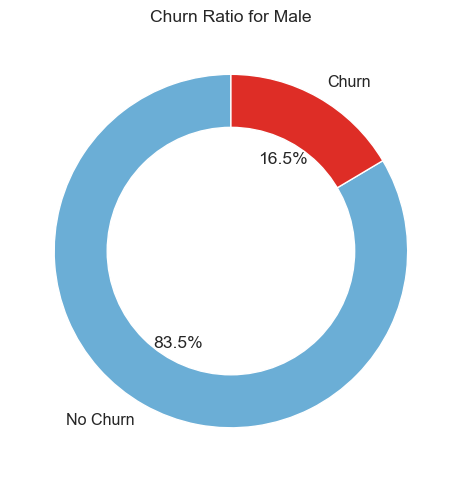

In [23]:
#  Why groupby gender?
#  To see churn behavior separately for males and females.
gender_counts = df.groupby('gender')['churn'] \
                   .value_counts(normalize=True) \
                   .unstack() \
                   .fillna(0)

#  Why donut chart?
#  Donut charts show proportions clearly and are business-friendly.
for gender in gender_counts.index:
    
    plt.figure(figsize=(5,5))
    plt.pie(
        gender_counts.loc[gender],
        labels=['No Churn', 'Churn'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['#6baed6', '#de2d26']
    )
    
    #  Why add a white circle?
    #  Converts pie chart into donut chart for clarity.
    center = plt.Circle((0,0), 0.70, fc='white')
    plt.gca().add_artist(center)
    
    plt.title(f'Churn Ratio for {gender}')
    plt.tight_layout()
    plt.show()


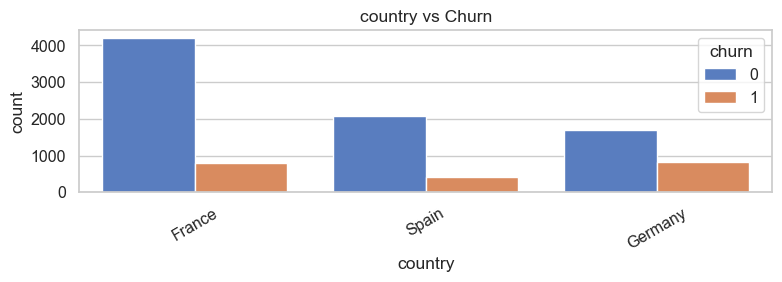

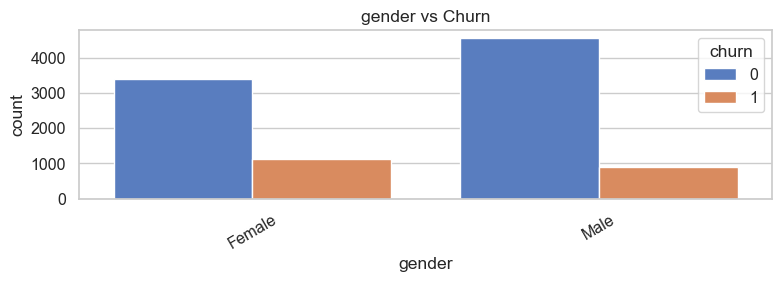

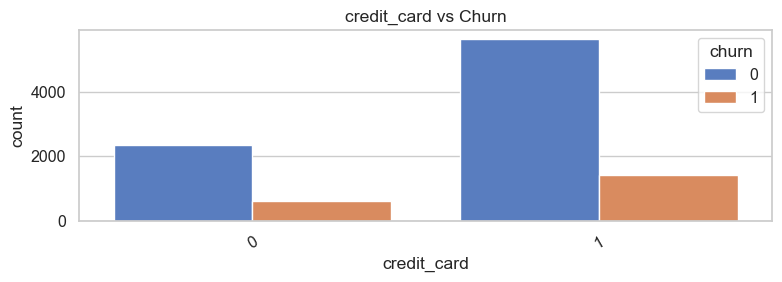

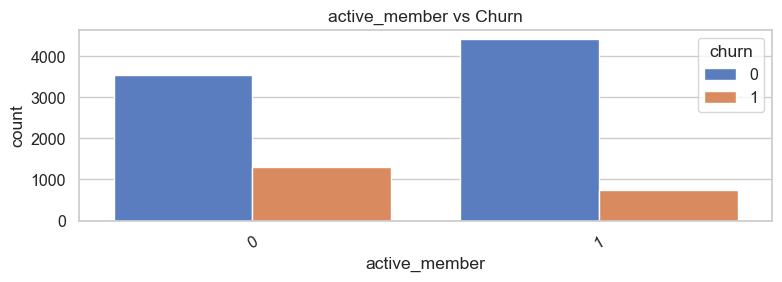

In [60]:
# --- Categorical features
cat_cols = ['country', 'gender', 'credit_card', 'active_member']
for c in cat_cols:
    plt.figure(figsize=(8,3))
    sns.countplot(data=df, x=c, hue='churn')
    plt.title(f'{c} vs Churn')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

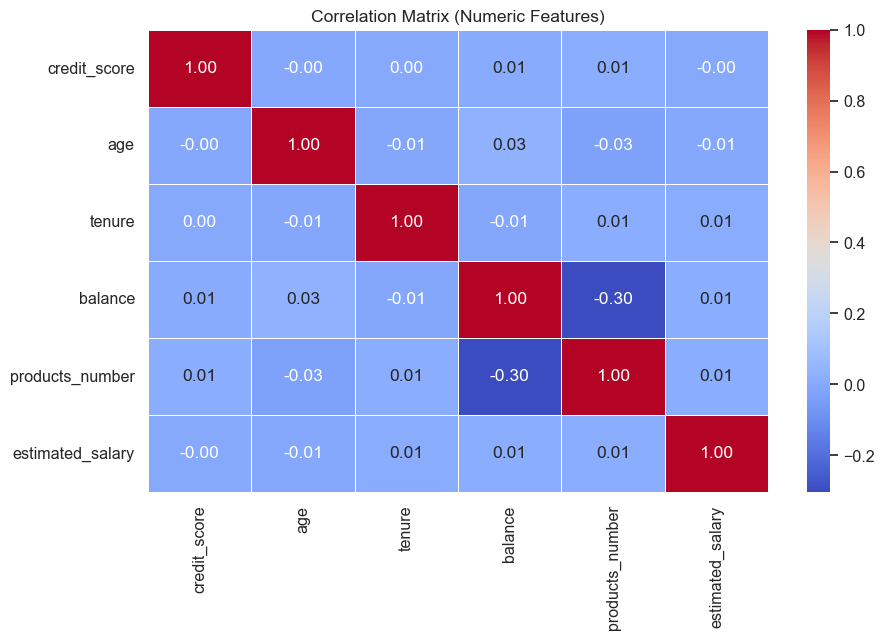

In [24]:
#  Why compute correlation?
#  To detect:
#    - Redundant features
#    - Multicollinearity
numeric_data = df[num_cols]
corr = numeric_data.corr()

#  Why heatmap?
#  Heatmap visualizes correlation strength and direction.
plt.figure(figsize=(10,6))
sns.heatmap(
    corr,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    linewidths=0.5
)

plt.title('Correlation Matrix (Numeric Features)')
plt.show()


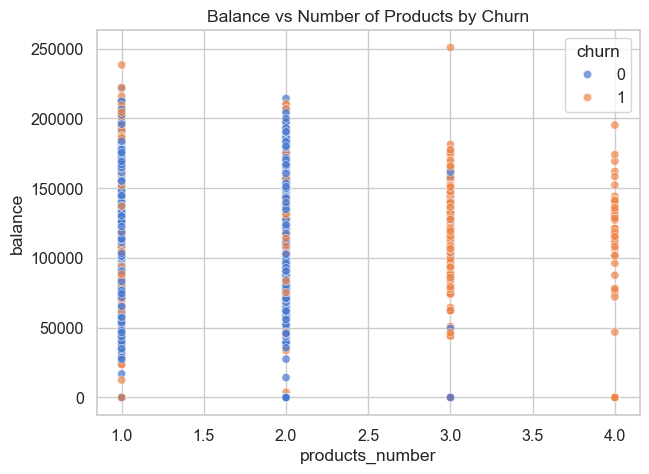

In [25]:
#  Why scatter plot?
#  To analyze interaction between two numeric variables.
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df,
    x='products_number',
    y='balance',
    hue='churn',
    alpha=0.7
)

plt.title('Balance vs Number of Products by Churn')
plt.show()


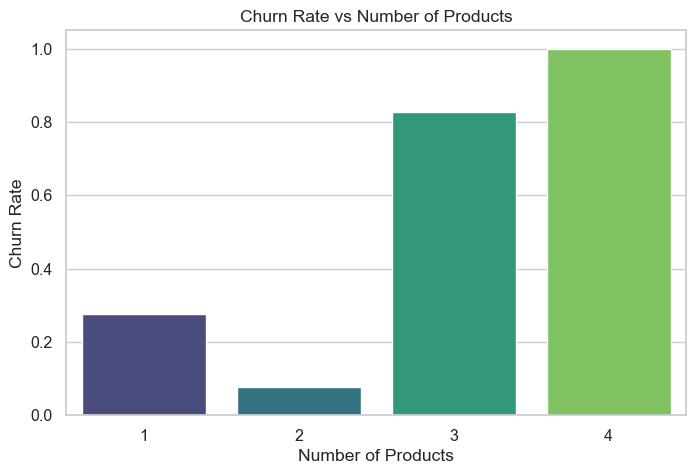

In [64]:
# --- Aggregate churn rate per number of products
churn_rate = df.groupby('products_number')['churn'].mean().reset_index()

# Plot churn rate
plt.figure(figsize=(8,5))
sns.barplot(data=churn_rate, x='products_number', y='churn', palette='viridis')
plt.xlabel('Number of Products')
plt.ylabel('Churn Rate')
plt.title('Churn Rate vs Number of Products')
plt.show()

# Step 5. Feature Engineering
Create meaningful features: e.g balance per product, age group, salary bracket and handle missing values.

In [13]:
# Feature engineering examples
df_fe = df.copy()

# Balance per product
df_fe['balance_per_product'] = df_fe['balance'] / (df_fe['products_number'].replace(0, np.nan))
df_fe['balance_per_product'].fillna(0, inplace=True)

# Salary to balance ratio
df_fe['salary_balance_ratio'] = df_fe['estimated_salary'] / (df_fe['balance'].replace(0, np.nan))
df_fe['salary_balance_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_fe['salary_balance_ratio'].fillna(df_fe['salary_balance_ratio'].median(), inplace=True)

# Age group
bins = [0,25,35,45,55,65,100]
labels = ['<25','25-34','35-44','45-54','55-64','65+']
df_fe['age_group'] = pd.cut(df_fe['age'], bins=bins, labels=labels)

# Tenure bucket
df_fe['tenure_bucket'] = pd.cut(df_fe['tenure'], bins=[-1,0,2,5,10,100], labels=['0','1-2','3-5','6-10','10+'])

# Flag high balance
df_fe['high_balance'] = (df_fe['balance'] > df_fe['balance'].quantile(0.75)).astype(int)

# Quick checks
df_fe[['balance_per_product','salary_balance_ratio','age','age_group','tenure','tenure_bucket','high_balance']].head()

,balance_per_product,salary_balance_ratio,age,age_group,tenure,tenure_bucket,high_balance
0,0.000000,0.839258,42,35-44,2,1-2,0
1,83807.860000,1.342864,41,35-44,1,1-2,0
2,53220.266667,0.713585,42,35-44,8,6-10,1
3,0.000000,0.839258,39,35-44,1,1-2,0
4,125510.820000,0.630098,43,35-44,2,1-2,0


# Step 6. Preprocessing - encoding & scaling
We'll build a preprocessing pipeline that encodes categorical features and scales numerical ones.

In [ ]:
#  Why define the target variable explicitly?
#  To clearly specify what the model should predict.
#  This improves readability and avoids hardcoding later.
target = 'churn'


#  Why define columns to drop?
#  'customer_id' is a unique identifier and has no predictive power.
#    Including it would introduce noise and potential data leakage.
drop_cols = ['customer_id']


#  Why create a features list dynamically
#  To automatically select all usable features except:
#    - target variable
#    - non-informative ID columns
#    This makes the code robust to future column additions.
features = [c for c in df_fe.columns if c not in [target] + drop_cols]


#  Why explicitly separate numeric features?
#  Numeric features require:
#    - Missing value imputation (median)
#    - Feature scaling (StandardScaler)
#    This list ensures correct preprocessing is applied.
numeric_features = [
    'credit_score',
    'age',
    'tenure',
    'balance',
    'products_number',
    'estimated_salary',
    'balance_per_product',
    'salary_balance_ratio'
]


#  Why explicitly separate categorical features
#  Categorical features require:
#    - Missing value imputation (most frequent)
#    - One-hot encoding
#    This avoids applying numeric transformations incorrectly.
categorical_features = [
    'country',
    'gender',
    'credit_card',
    'active_member',
    'age_group',
    'tenure_bucket',
    'high_balance'
]


#  Why cast categorical features as 'object'?
#  Ensures that ColumnTransformer treats these columns as categorical.
#    Prevents accidental numeric processing.
df_fe[categorical_features] = df_fe[categorical_features].astype('object')


#  Why create a numeric transformer pipeline
#  Pipelines ensure that:
#    - The same preprocessing is applied during training & inference
#    - No data leakage occurs
numeric_transformer = Pipeline([
    
    #  Why median imputation?
    #  Median is robust to outliers and skewed distributions.
    ('imputer', SimpleImputer(strategy='median')),
    
    #  Why StandardScaler?
    #  Scaling ensures all numeric features contribute equally,
    #    especially important for distance-based and linear models.
    ('scaler', StandardScaler())
])


#  Why create a categorical transformer pipeline?
#  Categorical variables need a different preprocessing strategy.
categorical_transformer = Pipeline([
    
    #  Why most_frequent imputation?
    #  Replacing missing categories with the most common value
    #  preserves the data distribution.
    ('imputer', SimpleImputer(strategy='most_frequent')),
    
    #  Why OneHotEncoder?
    #  Converts categorical variables into numeric format.
    #  handle_unknown='ignore' prevents inference-time errors
    #    when unseen categories appear.
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


#  Why use ColumnTransformer?
#  Allows different preprocessing steps for numeric and categorical features.
#  Keeps preprocessing clean, modular, and production-ready.
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


#  Why print feature lists?
#  Sanity check to confirm correct feature separation before modeling.
print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)


Numeric features: ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'estimated_salary', 'balance_per_product', 'salary_balance_ratio']
Categorical features: ['country', 'gender', 'credit_card', 'active_member', 'age_group', 'tenure_bucket', 'high_balance']


# Step 7. Train Test split

In [28]:
X = df_fe[features]
y = df_fe[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)
print('Train churn proportion:', y_train.mean(), 'Test churn proportion:', y_test.mean())

Train shape: (8000, 15) Test shape: (2000, 15)
Train churn proportion: 0.20375 Test churn proportion: 0.2035


# Step 8. Train Multiple models with a pipeline and compare using cross-validation

In [29]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=500),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=200, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=200, random_state=42),
    'SVC': SVC(probability=True, random_state=42)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', model)])
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    results[name] = scores
    print(f"{name} AUC: Mean={scores.mean():.4f} Std={scores.std():.4f}")

LogisticRegression AUC: Mean=0.7877 Std=0.0244
RandomForest AUC: Mean=0.8486 Std=0.0130
GradientBoosting AUC: Mean=0.8628 Std=0.0097
AdaBoost AUC: Mean=0.8462 Std=0.0133
SVC AUC: Mean=0.8351 Std=0.0104


# Observation: Model Comparison Using Cross-Validated ROC-AUC
Multiple machine learning models are defined to compare different learning approaches for churn prediction.

Logistic Regression is used as a baseline linear model.

Random Forest is used to capture non-linear relationships and feature interactions.

Gradient Boosting and AdaBoost are included to test boosting-based ensemble performance.

SVC is added to evaluate a margin-based classifier with probability outputs.

Stratified K-Fold cross-validation is used to ensure each fold maintains the same churn ratio.

Five folds are chosen to balance evaluation stability and computation time.

An empty dictionary is created to store cross-validation results for each model.

Each model is wrapped inside a pipeline to ensure preprocessing and training happen together.

Using a pipeline prevents data leakage during cross-validation.

Cross-validation is performed only on the training data to avoid test data contamination.

ROC-AUC is selected as the evaluation metric because the dataset is imbalanced.

Parallel processing (n_jobs=-1) is used to speed up computation.

Mean ROC-AUC represents the overall predictive ability of the model.

Standard deviation shows how stable the model performance is across folds.

Models with higher mean ROC-AUC and lower standard deviation are preferred.

This process enables fair and objective model comparison before final selection.

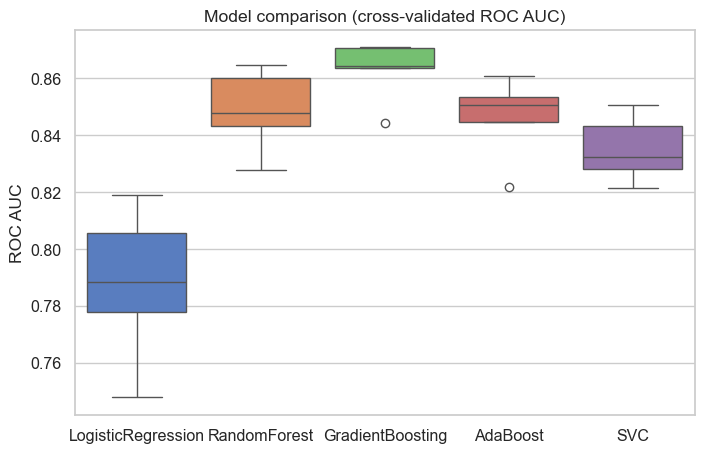

In [30]:
# Boxplot of CV AUC scores
plt.figure(figsize=(8,5))
sns.boxplot(data=[results[m] for m in list(results.keys())])
plt.xticks(ticks=range(len(results)), labels=list(results.keys()))
plt.ylabel('ROC AUC')
plt.title('Model comparison (cross-validated ROC AUC)')
plt.show()

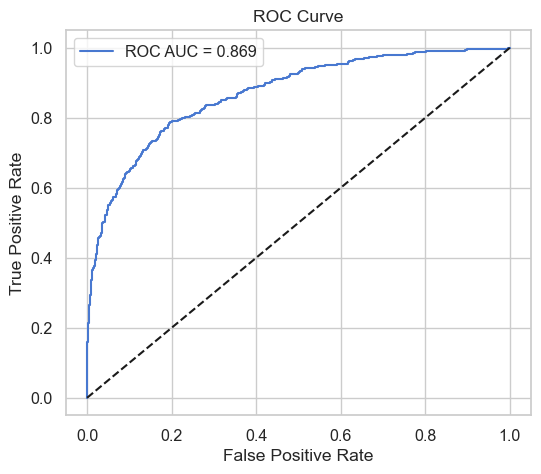

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get probabilities
y_prob = best_pipeline.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Plot
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_prob):.3f}')
plt.plot([0,1], [0,1], 'k--')  # Random model line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# why its use
The ROC-AUC boxplot compares multiple models using cross-validated scores.
Gradient Boosting achieves the highest and most stable ROC-AUC, indicating
strong discrimination ability for churn prediction. ROC-AUC is preferred
over accuracy due to class imbalance in the dataset.


# Step 9. Fit best model on full train set and evaluate on test set
Select best model by mean CV AUC above and evaluate standard metrics on the test set

In [31]:
# Choose best model (automatic pick by mean AUC)
best_name = max(results.keys(), key=lambda k: results[k].mean())
best_name, results[best_name].mean()

('GradientBoosting', np.float64(0.8627777349731776))

Test Accuracy: 0.8680
Test Precision: 0.7804
Test Recall: 0.4889
Test F1-score: 0.6012
Test ROC AUC: 0.8692

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.78      0.49      0.60       407

    accuracy                           0.87      2000
   macro avg       0.83      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000



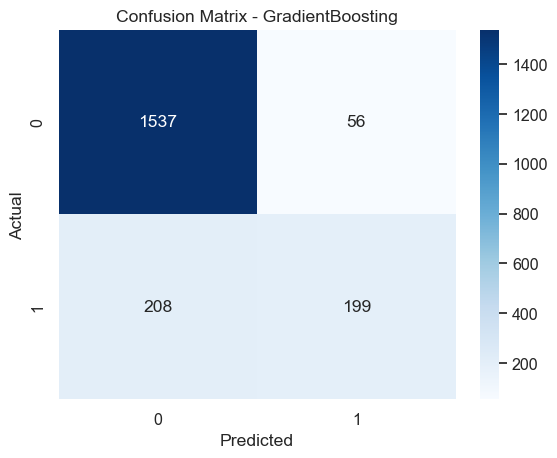

In [32]:
best_model = models[best_name]
best_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', best_model)])
best_pipeline.fit(X_train, y_train)

# Predictions
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:,1]

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall: {rec:.4f}")
print(f"Test F1-score: {f1:.4f}")
print(f"Test ROC AUC: {roc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_name}')
plt.show()

| Metric    | Why it’s used                               |
| --------- | ------------------------------------------- |
| Accuracy  | Overall correctness                         |
| Precision | Avoid false churn alerts                    |
| Recall    | Catch real churn customers (VERY IMPORTANT) |
| F1-score  | Balance precision & recall                  |
| ROC-AUC   | Overall separation ability                  |

observation-->I evaluated the final model using multiple metrics and a confusion matrix to ensure reliable churn detection on unseen data

# Step 10. Feature importance (if applicable)
If the chosen model supports feature importance (RandomForest/GradientBoosting), show top features

age                     0.327665
products_number         0.266459
balance_per_product     0.063396
balance                 0.056953
active_member_0         0.052653
country_Germany         0.050689
active_member_1         0.047992
salary_balance_ratio    0.029992
estimated_salary        0.025547
credit_score            0.022685
age_group_45-54         0.020634
age_group_55-64         0.007968
gender_Female           0.006850
gender_Male             0.006532
tenure                  0.005683
country_France          0.003164
tenure_bucket_3-5       0.001564
age_group_35-44         0.001415
credit_card_1           0.000697
country_Spain           0.000577
dtype: float64

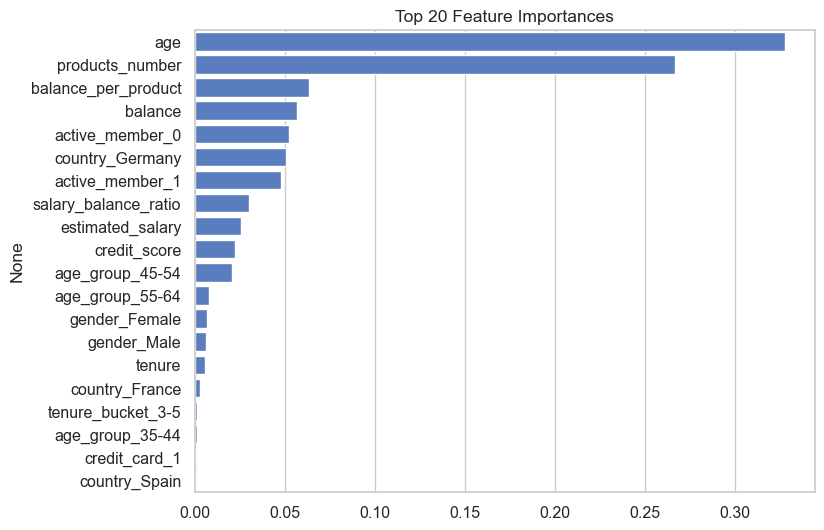

In [72]:
if hasattr(best_pipeline.named_steps['classifier'], 'feature_importances_'):
    num_feats = numeric_features
    cat_feats = list(best_pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features))
    feature_names = num_feats + cat_feats
    importances = best_pipeline.named_steps['classifier'].feature_importances_
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:20]
    display(fi)
    plt.figure(figsize=(8,6))
    sns.barplot(x=fi.values, y=fi.index)
    plt.title('Top 20 Feature Importances')
    plt.show()
else:
    print('Selected model does not provide feature_importances_ attribute.')

# Step 11. Save the best pipeline and preprocessing artifacts

In [33]:
joblib.dump(best_pipeline, 'best_churn_pipeline.pkl')
print("Saved pipeline: best_churn_pipeline.pkl")

Saved pipeline: best_churn_pipeline.pkl


# Step 12. Inference For The MODEL
Example: Predict churn for a new customer

In [34]:
# --- New customer sample ---
sample = {
    'customer_id': 373292028,
    'credit_score': 650,
    'country': 'France',
    'gender': 'Male',
    'age': 40,
    'tenure': 3,
    'balance': 50000.0,
    'products_number': 2,
    'credit_card': 1,
    'active_member': 1,
    'estimated_salary': 60000.0
}

sample_df = pd.DataFrame([sample])

# --- Apply same feature engineering ---
sample_df['balance_per_product'] = sample_df['balance'] / (sample_df['products_number'].replace(0, np.nan))
sample_df['balance_per_product'].fillna(0, inplace=True)

sample_df['salary_balance_ratio'] = sample_df['estimated_salary'] / (sample_df['balance'].replace(0, np.nan))
sample_df['salary_balance_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
sample_df['salary_balance_ratio'].fillna(sample_df['salary_balance_ratio'].median(), inplace=True)

bins = [0,25,35,45,55,65,100]
labels = ['<25','25-34','35-44','45-54','55-64','65+']
sample_df['age_group'] = pd.cut(sample_df['age'], bins=bins, labels=labels)

sample_df['tenure_bucket'] = pd.cut(sample_df['tenure'], bins=[-1,0,2,5,10,100], labels=['0','1-2','3-5','6-10','10+'])
sample_df['high_balance'] = (sample_df['balance'] > 50000.0).astype(int)  # can use 75th percentile of training set


# --- Drop ID ---
sample_df = sample_df.drop(columns=['customer_id'])

# --- Predict ---
pred = best_pipeline.predict(sample_df)[0]
prob = best_pipeline.predict_proba(sample_df)[0,1]

print(f'Predicted churn: {pred}, probability of churn: {prob:.3f}')

Predicted churn: 0, probability of churn: 0.030


# Why predict probabilities (predict_proba)

Churn is a risk problem, not just yes/no

Probability tells how likely a customer is to churn

Required for ROC-AUC

Goal: flexible business decisions (thresholds)